<a href="https://colab.research.google.com/github/vdnghia03/Deep-Learning/blob/main/DL5_Transfer_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Transfer learning CNN
---

Note for **transfer learning**.

<p class = "alert alert-info" role="alert"><b>Note</b> Should read reference below</p>

Read more:

- [Transfer learning wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)
- [Transfer learning on tf_flower - Nutan (2021) medium](https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc)
- [tf_flowers dataset - TensorFlow](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- [TensorSpec object - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/TensorSpec?version=nightly)
- [Image data preprocessing - TensorFlow](https://link)
- [transfer learning flower set- towardsdatascience](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)
- [ImageNet](https://www.image-net.org/index.php)
- [Keras applications](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
- [Remove layers keras - stackoverflow](https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights)

---

---
### Flower dataset
We'll move on to working with core tensorflow and their objects. Data will come from tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-white")

(train, test), info = tfds.load(
    "tf_flowers"
    , split = ["train[:80%]", "train[80%:]"]
    , as_supervised = True
    , with_info = True
)

info



tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [ ]:
label_names = ["daisy", "dandelion", "roses", "sunflower", "tulips"]
label_names

['daisy', 'dandelion', 'roses', 'sunflower', 'tulips']

In [ ]:
type(train.take(4))

tensorflow.python.data.ops.take_op._TakeDataset

image shape: (333, 500, 3), label: 2
image shape: (212, 320, 3), label: 3
image shape: (240, 320, 3), label: 3
image shape: (240, 320, 3), label: 4
image shape: (317, 500, 3), label: 3
image shape: (212, 320, 3), label: 0
image shape: (240, 240, 3), label: 0
image shape: (333, 500, 3), label: 0


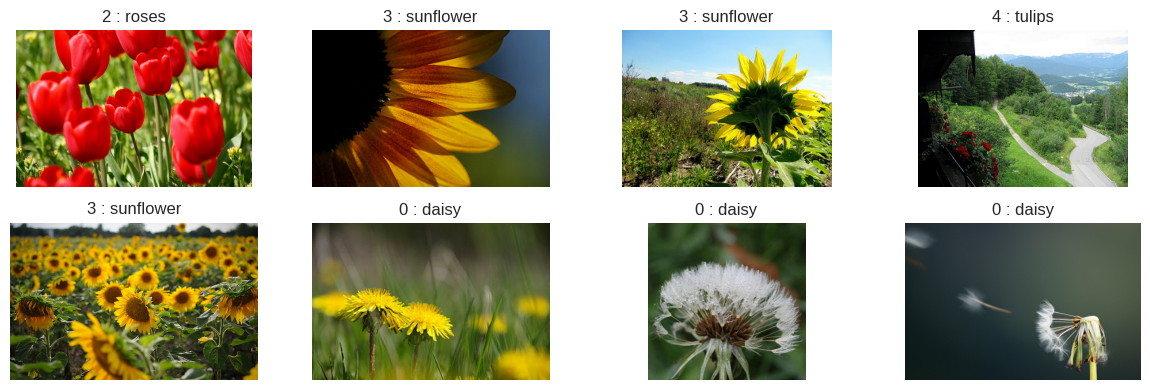

In [ ]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
  print(f"image shape: {img_sample[0].shape}, label: {img_sample[1]}")
  ax = axes.flatten()[i]
  ax.imshow(img_sample[0])
  ax.set_title(f"{img_sample[1]} : {label_names[img_sample[1]]}")
  ax.axis("off")

plt.tight_layout()



In [ ]:
print(train.take(2).get_single_element)

<bound method DatasetV2.get_single_element of <_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>>


---
### Preprocessing

- need to reshape the images
- scale them
- create batches
- optimize performance itilizing CPU and GPU with prefetching a batch

In [ ]:
def process_images(img, label, out_size = (120, 120)):
  # Resize -> width: 120 and height = 120
  img = tf.image.resize(img, out_size)
  # Scale image to down gradient
  img = img/255.0
  return img, label

input_shape = (120, 120, 3)
batch_size = 120

train_batch = train.shuffle(buffer_size = 600).map(process_images).batch(batch_size).prefetch(1)
test_batch  = test.map(process_images).batch(batch_size).prefetch(1)

test_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

---
### Transfer learning

There a few approaches to transfer learning and the approach we're using in this lecture note is:

1. Load a model which has been pretrained on a large dataset e.g. imagenet.
2. Remove the top, i.e. the classifier part and MLP part
3. Freeze the layers weights of the pretrained network. Reason for this is to use the pretrained weights to extract feature maps from new images which it hasn't seen before.
4. Add an MLP part and classifier part. Train the data on the last part.

Idea behind this is that we can reuse a network that is trained on large dataset as many kernels such as edge detectors, simple shape detectors can be used on other datasets as well. Also this is cheap as it is more data-expensive and computationally expensive to train a large network from scratch.

However some deeper layers extract more and more complicated structures that may be too specific for another dataset. Then another approach is to use the shallower layers for feature extraction and train the new dataset on the deeper layers to fine-tune the network. Then add an MLP part as in above.

In [ ]:
from tensorflow.keras.applications import Xception

feature_extractor = Xception(weights = "imagenet", include_top = False, input_shape = input_shape)
feature_extractor.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 59, 59,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 59, 59,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 59, 59,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 57, 57,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 57, 57,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 57, 57,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 57, 57,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 57, 57,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 57, 57,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 57, 57,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 57, 57,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 29, 29,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 29, 29,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 29, 29,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 29, 29,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 29, 29,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential(
    [
        feature_extractor,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ]
)

for layer in feature_extractor.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,309 (81.59 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - acc: 0.4778 - loss: 1.3282 - val_acc: 0.7847 - val_loss: 0.6238
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - acc: 0.7322 - loss: 0.7211 - val_acc: 0.8120 - val_loss: 0.5403
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - acc: 0.7631 - loss: 0.6262 - val_acc: 0.8283 - val_loss: 0.5003
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - acc: 0.8008 - loss: 0.5363 - val_acc: 0.8392 - val_loss: 0.4759
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - acc: 0.8132 - loss: 0.5153 - val_acc: 0.8379 - val_loss: 0.4643
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - acc: 0.8258 - loss: 0.4872 - val_acc: 0.8488 - val_loss: 0.4506
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - acc: 0.8303 - loss: 0.4776 - val_acc: 0.8447 - val_loss: 0.4495
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - acc: 0.8546 - loss: 0.4158 - val_acc: 0.8501 - val_loss: 0.4410
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - acc:

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,acc,loss,val_acc,val_loss
0,0.581063,1.068147,0.784741,0.623768
1,0.740804,0.690878,0.811989,0.540350
2,0.772480,0.615294,0.828338,0.500323
3,0.797684,0.552056,0.839237,0.475942
4,0.810627,0.512899,0.837875,0.464314


<Axes: >

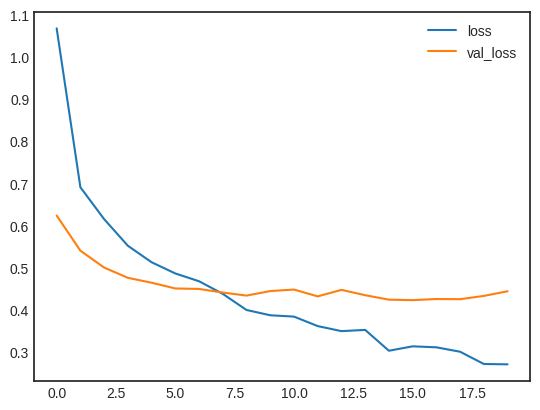

In [ ]:
metrics[["loss", "val_loss"]].plot()